In [1]:
import tensorflow as tf
def conv_block(x,num_filters,num_layers,block_name):
    for i in range(num_layers):
        
        x=tf.keras.layers.Conv2D(num_filters,(3,3),activation="relu",padding="same",name=f"{block_name}_conv{i+1}")(x)
    
    x=tf.keras.layers.MaxPooling2D((2,2),name=f"{block_name}_pool")(x)
    return x
def VGG16(input_tensor=(224,224,3),num_classes=1000):
    
    inputs=tf.keras.layers.Input(shape=input_tensor)
    
    x=conv_block(inputs,16,2,'block1')
    
    x=conv_block(x,32,2,'block2')
    
    x=conv_block(x,64,3,'block3')
    
    x=conv_block(x,128,3,'block4')
    
    x=conv_block(x,128,3,'block5')
    
    x=tf.keras.layers.Flatten()(x)
    
    x=tf.keras.layers.Dense(1024,activation="relu")(x)
    x=tf.keras.layers.Dense(1024,activation="relu")(x)
    
    outputs=tf.keras.layers.Dense(num_classes,activation="softmax")(x)
    
    model=tf.keras.models.Model(inputs,outputs)
    return model


2024-04-16 14:19:01.318262: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-16 14:19:01.349863: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 14:19:01.870469: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255)


validation_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(
    '/home/developer/Desktop/brain tumor(3)/train',
    target_size=(299,299),
    batch_size=128,
    class_mode='sparse'
)

dev_generator=validation_datagen.flow_from_directory(
    '/home/developer/Desktop/brain tumor(3)/val',
    target_size=(299,299),
    batch_size=32,
    class_mode='sparse'
)
test_generator=test_datagen.flow_from_directory(
    '/home/developer/Desktop/brain tumor(3)/test',
    target_size=(299,299),
    batch_size=32,
    class_mode='sparse'
)

Found 21434 images belonging to 4 classes.
Found 1233 images belonging to 4 classes.
Found 3050 images belonging to 4 classes.


In [3]:
import matplotlib.pyplot as plt

def visualize_generator(generator, num_images=10):

    class_labels = list(generator.class_indices.keys())
    
    images, labels = next(generator)

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(images[i])
        plt.title(class_labels[int(labels[i])])
        plt.axis('off')
    plt.show()

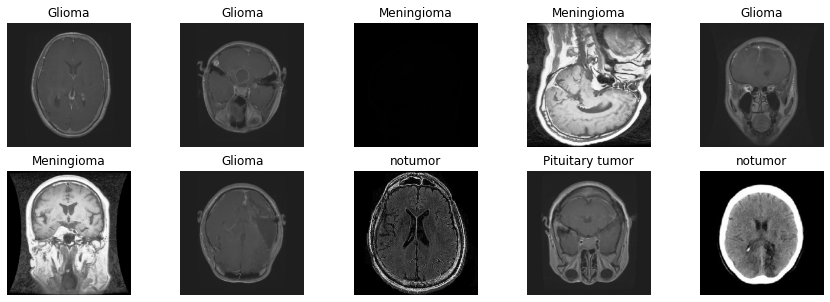

In [4]:
visualize_generator(train_generator,10)

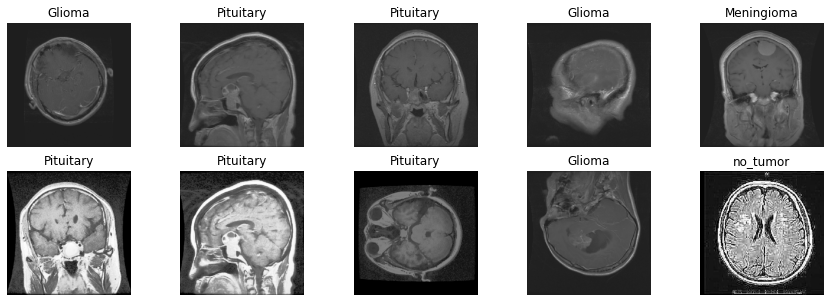

In [5]:
visualize_generator(test_generator,10)

In [2]:
model=VGG16(input_tensor=(299,299,3),num_classes=4)

2024-04-16 14:19:09.002472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 14:19:09.007284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 14:19:09.007755: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer=tf.optimizers.Adam(),metrics=['accuracy'])


In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 16)      448       
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 16)      2320      
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 16)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 32)      4640      
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 32)      9248      
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 32)        0     

In [9]:

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="best_model_VGG16.h5", monitor="val_accuracy", save_best_only=True)
csvlogger_callback=tf.keras.callbacks.CSVLogger('model_VGG16.csv', separator=",", append=True)
early_callback=tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=5)

In [10]:
history=model.fit(train_generator,epochs=10,validation_data=test_generator,callbacks=[model_checkpoint_callback,csvlogger_callback])


Epoch 1/10


2024-04-15 14:42:33.232908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/home/developer/anaconda3/lib/python3.9/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-04-15 14:42:35.185706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-04-15 14:42:35.603639: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-15 14:42:37.402036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-3

168/168 [==============================] - ETA: 0s - loss: 0.8393 - accuracy: 0.5957

2024-04-15 14:44:01.024367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


168/168 [==============================] - 97s 455ms/step - loss: 0.8393 - accuracy: 0.5957 - val_loss: 0.4865 - val_accuracy: 0.7859
Epoch 2/10
168/168 [==============================] - 70s 417ms/step - loss: 0.4508 - accuracy: 0.7988 - val_loss: 0.4479 - val_accuracy: 0.7931
Epoch 3/10
168/168 [==============================] - 72s 430ms/step - loss: 0.3383 - accuracy: 0.8536 - val_loss: 0.2630 - val_accuracy: 0.8780
Epoch 4/10
168/168 [==============================] - 72s 424ms/step - loss: 0.2155 - accuracy: 0.9122 - val_loss: 0.1217 - val_accuracy: 0.9584
Epoch 5/10
168/168 [==============================] - 69s 406ms/step - loss: 0.1434 - accuracy: 0.9438 - val_loss: 0.0913 - val_accuracy: 0.9708
Epoch 6/10
168/168 [==============================] - 69s 407ms/step - loss: 0.0874 - accuracy: 0.9670 - val_loss: 0.0818 - val_accuracy: 0.9738
Epoch 7/10
168/168 [==============================] - 68s 406ms/step - loss: 0.0701 - accuracy: 0.9749 - val_loss: 0.0684 - val_accuracy: 0.9

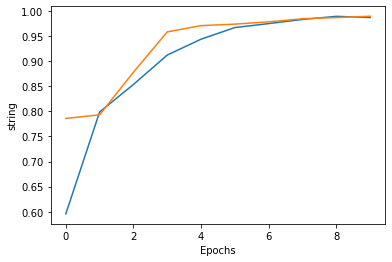

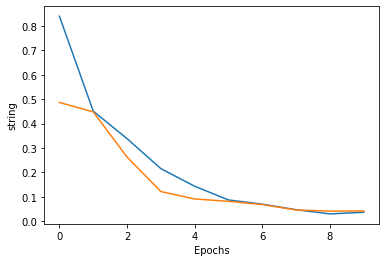

In [11]:
def plot_graphs(history,string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel("string")
    plt.show()
plot_graphs(history,'accuracy')
plot_graphs(history,'loss')

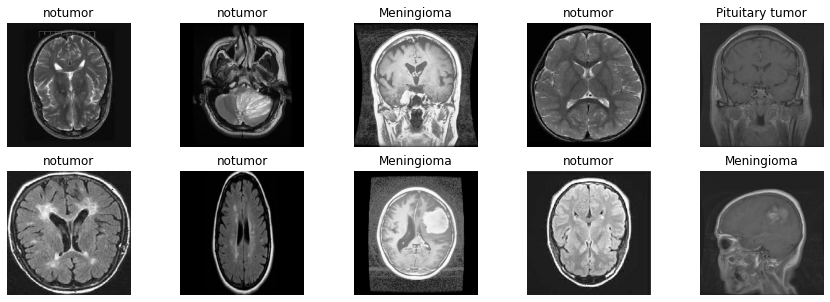

In [12]:
visualize_generator(dev_generator,10)

In [13]:
model.evaluate(dev_generator)

 2/39 [>.............................] - ETA: 2s - loss: 0.2449 - accuracy: 0.9375

2024-04-15 14:54:48.506723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


39/39 [==============================] - 3s 80ms/step - loss: 0.1801 - accuracy: 0.9603


[0.18006835877895355, 0.9602595567703247]

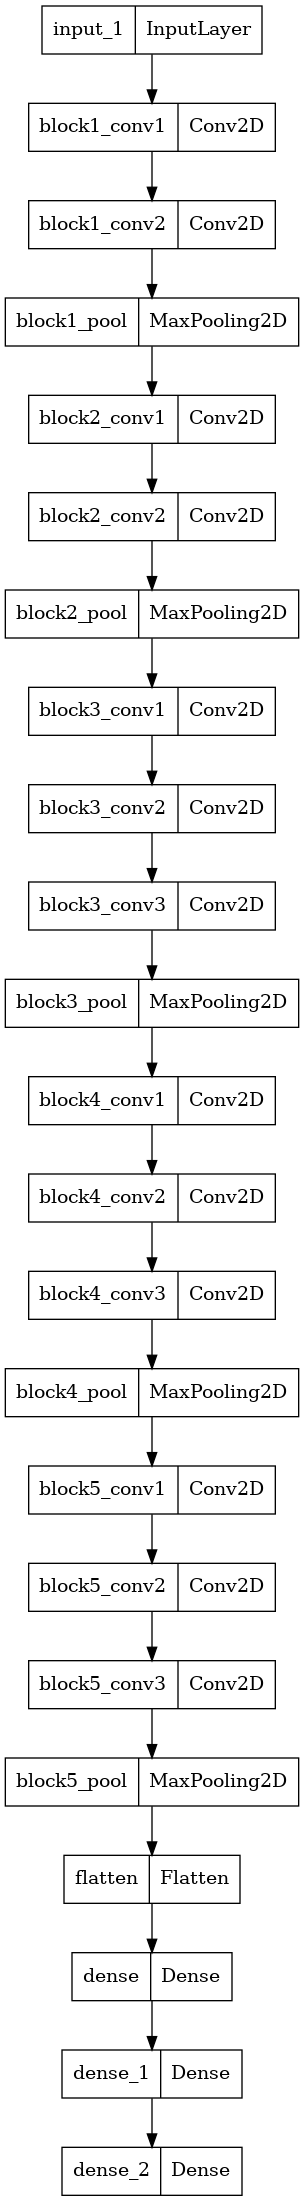

In [5]:
tf.keras.utils.plot_model(model,to_file="VGG16.png")